In [1]:
## good for development
%load_ext autoreload
%autoreload 2

# Do the wavelet transform of the maps

In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import healpy as hp
import gmca4im_lib2 as g4i


In [3]:
file = h5py.File('../sim_5MHz.hd5','r')

In [4]:
file.keys()

<KeysViewHDF5 ['cosmological_signal', 'frequencies', 'gal_ff', 'gal_synch', 'noise', 'point_sources', 'pol_leakage']>

In [5]:
components = ['cosmological_signal', 'gal_ff', 'gal_synch', 'noise', 'point_sources', 'pol_leakage']

In [6]:
nu_ch = np.array(file['frequencies'])

In [7]:
len(nu_ch)

80

Preparing the observed map (sum of all components + noise):

In [8]:
npix = np.shape(file['cosmological_signal'])[1]
obs_maps = np.zeros((len(nu_ch),npix))

for c in components:
    print(c)
    tmp_component = np.array(file[c])
    obs_maps += tmp_component
    del tmp_component
    
## remove mean
obs_maps = np.array([[obs_maps[i] - np.mean(obs_maps[i],axis=0)] for i in range(len(nu_ch))])
obs_maps = obs_maps[:,0,:]

cosmological_signal
gal_ff
gal_synch
noise
point_sources
pol_leakage


Running the wavelet transform of maps:

In [9]:
## wavelet transform it
X_wt = g4i.wavelet_transform(obs_maps)


Wavelet transforming the data . . .
. . completed in 14.77 minutes



In [17]:
X_wt.shape

(40, 2359296)

#### Let's have a look at the eigenvalues

In [22]:
## function for extracting eigenvalues
def EVN(X):
    C_ij = np.cov(X) #Obtain frequency covariance matrix for input data
    # Get the eigenvalues and eigenvectors of covariance matrix:
    eigenval, eigenvec = np.linalg.eigh(C_ij)
    eigenval = eigenval[::-1] # largest eigenvals first
    del eigenvec

    return eigenval

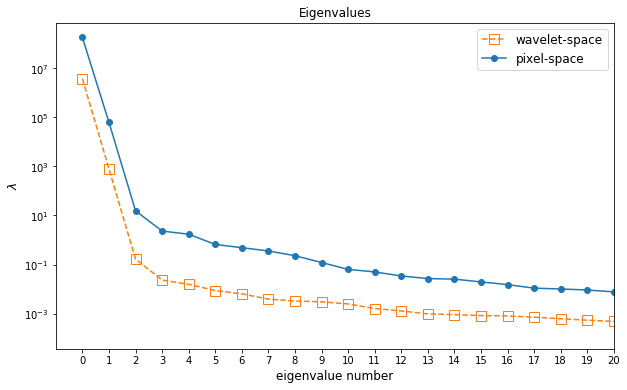

In [57]:
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["axes.labelsize"] = 12

plt.semilogy(EVN(X_wt),'--s',c='#ff7f0e',mfc='none',markersize=10,label='wavelet-space')
plt.semilogy(EVN(obs_maps),'-o',c='#1f77b4',markersize=6,label='pixel-space')

plt.legend(fontsize=12)
x_ticks = np.arange(25)
ax = plt.gca()
ax.set(xlim=[-1,20],xticks=x_ticks,xlabel="eigenvalue number",ylabel="$\\lambda$",title='Eigenvalues');



# Let's run GMCA

In [61]:
################   GMCA PARAMETERS   ##################
n_s   = 3   # number of sources to be estimated
mints = 0.1 # min threshold
nmax  = 100 # number of iterations
L0    = 0   # switch between L0 norm (1) or L1 norm (0)
#######################################################

# initial guess for the mixing matrix?
# i.e. we could start from PCA-determined mix matrix
AInit = None

# we can impose a column of the mixing matrix
ColFixed = None

# we can whiten the data
whitening = False; epsi = 1e-3

# estimated mixing matrix:
Ae = g4i.run_GMCA(X_wt,AInit,n_s,mints,nmax,L0,ColFixed,whitening,epsi)


Now running GMCA . . .
. . completed in 3.11 minutes



#### Let's have a look at the column of the mixing matrix

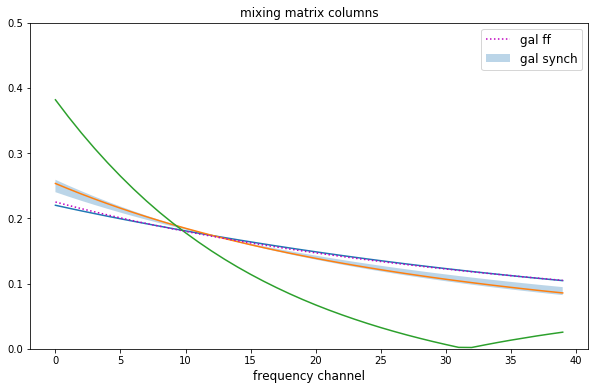

In [92]:
# gal freefree spectral index for reference
FF_col = np.array([nu_ch**(-2.13)]).T 

# gal synchrotron spectral index region for referencex = np.arange(0,len(nu_ch))
sync_A = np.array([nu_ch**(-3.2)]).T; y1 = sync_A/np.linalg.norm(sync_A)
sync_B = np.array([nu_ch**(-2.6)]).T; y2 = sync_B/np.linalg.norm(sync_B)

### actual plotting
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["axes.labelsize"] = 12

x = np.arange(0,len(nu_ch))

plt.fill_between(x,y1.T[0],y2.T[0],alpha=0.3,label='gal synch')
plt.plot(abs(Ae/np.linalg.norm(Ae,axis=0)))
plt.plot(FF_col/np.linalg.norm(FF_col),'m:',label='gal ff')

ax = plt.gca()
ax.set(ylim=[0.0,0.5],xlabel="frequency channel",title='mixing matrix columns');
plt.legend(fontsize=12);

### Did we recovered the foregrounds?

In [94]:
# original maps
obs_maps = np.zeros((len(nu_ch),npix))

for c in components:
    print(c)
    tmp_component = np.array(file[c])
    obs_maps += tmp_component
    del tmp_component

cosmological_signal
gal_ff
gal_synch
noise
point_sources
pol_leakage


In [95]:
#### reconstructed maps by GMCA
piA = np.linalg.inv(Ae.T@Ae)@Ae.T
# reproject onto original maps 
Se_sph = piA@obs_maps # LS estimate of the sources in the pixel domain
X_gmca = Ae@Se_sph; del Se_sph, piA

Let's have a look

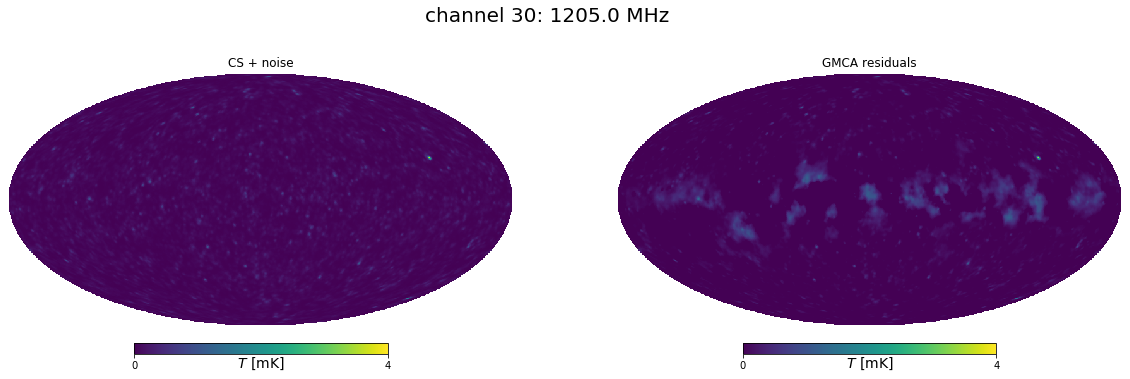

In [138]:
# pick a channel number to image
ich = 30

map_input = file['cosmological_signal'][ich]+file['noise'][ich] 
residuals = obs_maps[ich]-X_gmca[ich]

fig = plt.figure(figsize=(20, 6))
fig.suptitle(f'channel {ich}: {nu_ch[ich]} MHz',fontsize=20)
ax1 = fig.add_subplot(1,2,1)
plt.axes(ax1)
hp.mollview(map_input,min=0,max=4,title='CS + noise',unit=r'$T$ [mK]',hold=True)
ax2 = fig.add_subplot(1,2,2)
plt.axes(ax2)
hp.mollview(residuals,min=0,max=4,title='GMCA residuals',unit=r'$T$ [mK]',hold=True)

del map_input, residuals

Looking at angular power spectrum:

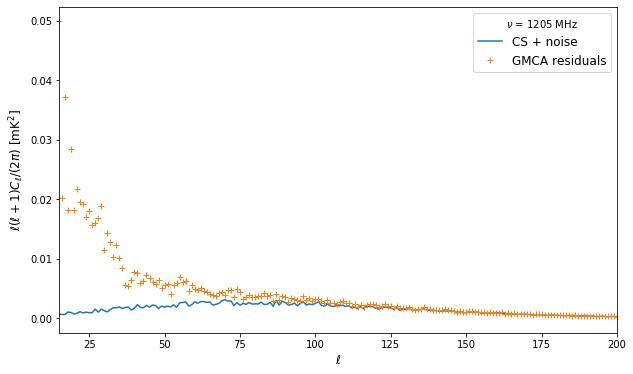

In [139]:
# pick a channel number
ich = 30

map_input = file['cosmological_signal'][ich]+file['noise'][ich] 
residuals = obs_maps[ich]-X_gmca[ich]

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["axes.labelsize"] = 12

ell, y = g4i.plot_cl(map_input)
plt.plot(ell, y,'-',c='#1f77b4',label='CS + noise');
ell, y = g4i.plot_cl(residuals)
plt.plot(ell,y,'+',c='#ff7f0e',label='GMCA residuals')

plt.legend(title='$\\nu$ = '+'%4.f'%nu_ch[ich]+' MHz',fontsize=12)
ax = plt.gca()
ax.set(xlim=[15,200],xlabel="$\\ell$",ylabel="$\\ell(\\ell+1)C_{\\ell}/(2\\pi)$ [mK$^2$]");

